In [1]:
#Packages
import os
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
#Get Data
csv_dir = '../SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

print(all_pitches.shape)
print(all_pitches.columns)

(270589, 167)
Index(['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher',
       'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter',
       ...
       'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2', 'PitchReleaseConfidence',
       'PitchLocationConfidence', 'PitchMovementConfidence',
       'HitLaunchConfidence', 'HitLandingConfidence',
       'CatcherThrowCatchConfidence', 'CatcherThrowReleaseConfidence',
       'CatcherThrowLocationConfidence'],
      dtype='object', length=167)


In [3]:
#Get all splitters
os_sp = all_pitches[all_pitches['TaggedPitchType'].isin(['Splitter'])]
print(os_sp.shape)

(1166, 167)


In [4]:
#Subset splitters into platoon splits
os_sp_rr = os_sp[(os_sp['PitcherThrows'] == 'Right') & (os_sp['BatterSide'] == 'Right')]
os_sp_rl = os_sp[(os_sp['PitcherThrows'] == 'Right') & (os_sp['BatterSide'] == 'Left')]
os_sp_lr = os_sp[(os_sp['PitcherThrows'] == 'Left') & (os_sp['BatterSide'] == 'Right')]
os_sp_ll = os_sp[(os_sp['PitcherThrows'] == 'Left') & (os_sp['BatterSide'] == 'Left')]

print(os_sp_rr.shape)
print(os_sp_rl.shape)
print(os_sp_lr.shape)
print(os_sp_ll.shape)

(284, 167)
(517, 167)
(322, 167)
(43, 167)


In [5]:
#Whiffs
os_sp_rr['whiff'] = np.where(os_sp_rr['PitchCall']=='StrikeSwinging',1,0)
os_sp_rl['whiff'] = np.where(os_sp_rl['PitchCall']=='StrikeSwinging',1,0)
os_sp_lr['whiff'] = np.where(os_sp_lr['PitchCall']=='StrikeSwinging',1,0)
os_sp_ll['whiff'] = np.where(os_sp_ll['PitchCall']=='StrikeSwinging',1,0)

C:\Users\ethan\AppData\Local\Temp\ipykernel_19092\234080586.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  os_sp_rr['whiff'] = np.where(os_sp_rr['PitchCall']=='StrikeSwinging',1,0)
C:\Users\ethan\AppData\Local\Temp\ipykernel_19092\234080586.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  os_sp_rl['whiff'] = np.where(os_sp_rl['PitchCall']=='StrikeSwinging',1,0)
C:\Users\ethan\AppData\Local\Temp\ipykernel_19092\234080586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [6]:
#Predictor Variables
preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

Righty vs Righty split

In [7]:
os_sp_rr_X = os_sp_rr[preds]
os_sp_rr_y = os_sp_rr['whiff']

In [8]:
#Train Model: RHP vs RHB
X_train, X_test, y_train, y_test = train_test_split(os_sp_rr_X, os_sp_rr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 85.11%


ROC AUC: 0.6570


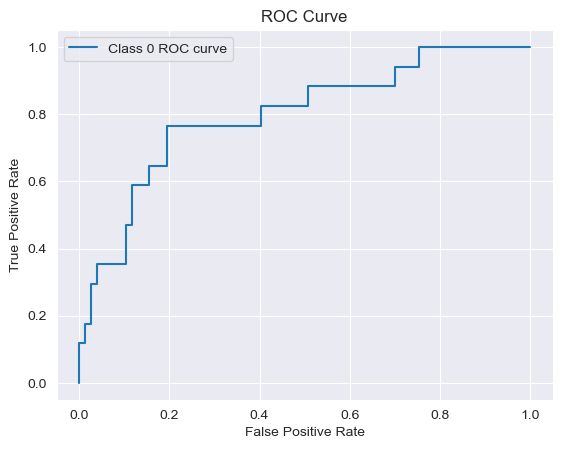

In [9]:
y_pred_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')

print(f'ROC AUC: {roc_auc:.4f}')

# Plotting ROC Curve for one class (e.g., class 0)
fpr, tpr, _ = roc_curve(y_test == 1, y_pred_prob)
plt.plot(fpr, tpr, label='Class 0 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [16]:
# Get unique values
unique_values = os_sp_rr['Pitcher'].unique()


#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: os_sp_rr[os_sp_rr['Pitcher'] == value] for value in unique_values}

46
['Alberghini, Kaden' 'Frank, Koty' 'Martinez, Javier' 'Davis, Ethan'
 'Allsup, Chase' 'Alexander, Ethan' 'Moore, Grayson' 'Franklin, Zach'
 'Waldrep, Hurston' 'Foutch, Christian' 'Johnson, Lebarron' 'Sexton, Ty'
 'Gartman, Landon' 'Newman, Jeremiah' 'Gaeto, Alex' 'Ficarrotta, Nick'
 'Dollander, Chase' 'McCoy, James' 'Austin, Cade' 'Greenler, Kyle'
 'Lindsey, Andrew' 'Lunceford, Logan' 'Schuelke, Cam' 'Tilly, Cameron'
 'Galdoni, Lukas ' 'Parlin, Bryce' 'Brown, Rese' 'Birkman, Owen'
 'Pryor, Will' 'Johnson, Ben' 'Chabot, Julian' 'Badmaev, Zane'
 'Guisewite, Caleb' "O'Brien, Liam" 'Cleveland, Jackson' 'Holman, Luke'
 'Grotyohann, Connor' 'Kasper, Sean' 'Manase, Seti' 'Vogel, Jacob'
 'Nichols, Mason' 'Varnadoe, Hunter' 'Quinn, Victor' 'Pitzer, Tyler'
 'Mayer, Bryce' 'Wood, Gage'] 46


In [11]:
def rr_os_sp_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(os_sp_rr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)

    


In [18]:
#Stuff+ for selected pitchers Splitter in RHP v RHB split
rr_os_sp_stuff('Tilly, Cameron')

120.82684

Righty vs. Lefty Split

In [19]:
os_sp_rl_X = os_sp_rl[preds]
os_sp_rl_y = os_sp_rl['whiff']

In [20]:
#Train Model: RHP vs LHB
X_train, X_test, y_train, y_test = train_test_split(os_sp_rl_X, os_sp_rl_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.63%


In [21]:
# Get unique values
unique_values = os_sp_rl['Pitcher'].unique()

#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: os_sp_rl[os_sp_rl['Pitcher'] == value] for value in unique_values}

['Leaverton, Blake' 'Martinez, Javier' 'Cleveland, Jackson' 'Frank, Koty'
 'Adcock, Cody' 'Zwitzer, Jurgen' 'Castro, Josiah' 'Moore, Grayson'
 'Schroeder, Austin' 'Santos, Nolan' 'Foutch, Christian' 'Franklin, Zach'
 'Allsup, Chase' 'Waldrep, Hurston' 'Ficarrotta, Nick' 'Johnson, Lebarron'
 'Sexton, Ty' 'Marsh, Chandler' 'Lunceford, Logan' 'Wood, Gage'
 'Fluno, Carson' 'Hoopes, Hunter' 'Cortez, Christopher' 'Austin, Cade'
 'Schuelke, Cam' 'Badmaev, Zane' 'Galdoni, Lukas ' 'Parlin, Bryce'
 'Schaefer, Derek' 'Brown, Rese' 'Dutkanych, Andrew' 'Birkman, Owen'
 'Mariano, Matthew' 'Duby, Bill' 'Johnson, Ben' 'Chabot, Julian'
 "O'Brien, Liam" 'Dossett, Cooper' 'McCoy, James' 'Brewer, Alex'
 'Holman, Luke' 'Grotyohann, Connor' 'Chadwick, Tyrelle' 'Morrow, Kanin'
 'Tilly, Cameron' 'Manase, Seti' 'Vogel, Jacob' 'MacRae, Coleman'
 'Kingsbery, Fischer' 'McGonigal, Paddy' 'Roberge, Josh'] 51


In [22]:
def rl_os_sp_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(os_sp_rl_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)


In [24]:
#Stuff+ for selected pitchers Splitter in RHP v LHB split
rl_os_sp_stuff('Tilly, Cameron')

160.62231

Lefty vs. Righty Split

In [25]:
os_sp_lr_X = os_sp_lr[preds]
os_sp_lr_y = os_sp_lr['whiff']

In [26]:
#Train Model: LHP vs RHB
X_train, X_test, y_train, y_test = train_test_split(os_sp_lr_X, os_sp_lr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.24%


In [27]:
# Get unique values
unique_values = os_sp_lr['Pitcher'].unique()

#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: os_sp_lr[os_sp_lr['Pitcher'] == value] for value in unique_values}


['Morris, Zack' 'Smith, Hagen' 'Keithley, Carson' 'Prager, Ryan'
 'Doyle, Liam' 'Lourens, Je-Andrick' 'Riggins, Miller' 'Ramos, Rigo'
 'Reed, Kevin' 'Sharp, Brayden' 'Dietz, Hunter' 'Huffling, Max'
 'Ackenhausen, Nathan' 'Behnke, Andrew'] 14


In [28]:
def lr_os_sp_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(os_sp_lr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)


In [29]:
#Stuff+ for selected pitchers Splitter in LHP v RHB split
lr_os_sp_stuff('Ackenhausen, Nathan')

197.50195

Lefty vs. Lefty Split

In [30]:
os_sp_ll_X = os_sp_ll[preds]
os_sp_ll_y = os_sp_ll['whiff']

In [32]:
#Train Model: LHP vs LHB
X_train, X_test, y_train, y_test = train_test_split(os_sp_ll_X, os_sp_ll_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 60.00%


In [33]:
# Get unique values
unique_values = os_sp_ll['Pitcher'].unique()

#List of Pitchers that threw splitter, as well as amount
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: os_sp_ll[os_sp_ll['Pitcher'] == value] for value in unique_values}


['Morris, Zack' 'Cijntje, Jurrangelo' 'Johnston, Will' 'Fisher, Colin'
 'Prager, Ryan' 'Lourens, Je-Andrick' 'Mahan, Ethan' 'Doyle, Liam'
 'Reed, Kevin' 'Heiberger, Matthew' 'Smith, Hagen' 'Huffling, Max'] 12


In [34]:
def ll_os_sp_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(os_sp_ll_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)


In [40]:
#Stuff+ for selected pitchers Splitter in LHP v LHB split
ll_os_sp_stuff('Prager, Ryan')

109.342415